# Importing libraries

In [1]:
import os
import cv2
from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import uuid

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

### setting gpu growth

In [4]:
tf.config.list_physical_devices('GPU')

2023-05-01 22:14:50.408656: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 22:14:50.465452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 22:14:50.465588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
#setting gpu growth
gpu = tf.config.experimental.list_physical_devices('GPU')
for g in gpu:
    tf.config.experimental.set_memory_growth(g, True)

### Creating path

In [6]:
pospath = os.path.join('../data', 'positive')
negpath = os.path.join('../data', 'negative')
anchor = os.path.join('../data', 'anchor')

In [7]:
# os.makedirs(pospath)
# os.makedirs(negpath)
# os.makedirs(anchor)

## For accessing camera and to take postive and anchor pictures

In [8]:
cap  = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()  
    frame = frame[:360, :513, :]
    cv2.imshow('image', frame)   
    
    if cv2.waitKey(1) & 0XFF == ord('a'):
        img = os.path.join(anchor, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img, frame)
        
    if cv2.waitKey(1) & 0XFF == ord('p'):
        img = os.path.join(pospath, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(img, frame)
        
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()    

## image processing (to get below 360x720px)

In [9]:
for negimg in os.listdir(negpath):
    img = cv2.imread(os.path.join(negpath, negimg))
    img = cv2.resize(img, None, fx=0.731, fy=0.731)
    cv2.imwrite(os.path.join(negpath, negimg), img)

In [26]:
img = cv2.imread(r'data\negative\000_left_ear.jpg')

[ WARN:0@2341.558] global loadsave.cpp:244 findDecoder imread_('data\negative\000_left_ear.jpg'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

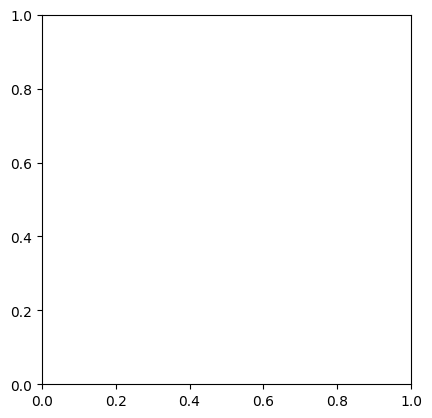

In [27]:
plt.imshow(img)

## TO process image(rotate 90degree clockwise)

In [12]:
for img in os.listdir(anchor):
    a = cv2.imread(os.path.join(anchor, img))
    a = cv2.rotate(a, cv2.ROTATE_90_CLOCKWISE)
    cv2.imwrite(os.path.join(anchor, img), a)


In [13]:
# for directories in os.listdir("lfw"):
#     for files in os.listdir(os.path.join('lfw',directories)):
#         ex = os.path.join("lfw", directories, files)
#         new = os.path.join(negpath, files)
#         os.replace(ex, new)

## Data Augmentation

In [14]:
def aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data



In [15]:
def data_aug(path):
    for file_name in os.listdir(path):
        img_path = os.path.join(path, file_name)
        img = cv2.imread(img_path)
        augmented_images = aug(img)

        for image in augmented_images:
            cv2.imwrite(os.path.join(path, '{}.jpg'.format(uuid.uuid1())), image.numpy())


In [16]:
with tf.device('/gpu:0'):
    data_aug(negpath)

2023-05-01 22:18:07.291670: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 22:18:07.293253: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 22:18:07.293419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-01 22:18:07.293524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## creating tf dataset from the data

In [18]:
def createdataset(path):
    return tf.data.Dataset.list_files(path+"/*.jpg").take(500) 

In [19]:
pos = createdataset(pospath)
neg = createdataset(negpath)
anch = createdataset(anchor)


In [20]:
print(pos, neg, anch, sep='\n')

<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>
<TakeDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>


In [21]:
test = pos.as_numpy_iterator()
test.next()

b'../data/positive/f18b9ffa-d6a1-11ed-8218-e45e37ecec6b.jpg'

In [25]:
tf.data.Dataset.from_tensor_slices(tf.fill([1,len(anch)],2))

tf.Tensor(
[[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
  2 2 2 2 2 2 2 2 2 2 2 2 2

## zipping the dataset as anchor with validation image and concatenating

In [35]:
positives = tf.data.Dataset.zip((anch, pos, tf.data.Dataset.from_tensor_slices(tf.fill([1,], len(anch)))))
negatives = tf.data.Dataset.zip((anch, neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anch)))))
rawdata = positives.concatenate(negatives)

In [36]:
print(positives, negatives, rawdata, sep='\n')

<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
<ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>
<ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [37]:
test = rawdata.as_numpy_iterator()
test.next()

(b'../data/anchor/d242b028-d6a0-11ed-a488-e45e37ecec6b.jpg',
 b'../data/positive/d4a19c1f-d6a1-11ed-b72c-e45e37ecec6b.jpg',
 1.0)

## image preprocessing

In [38]:
def preprocess(path):
    byteimg = tf.io.read_file(path)
    img = tf.io.decode_jpeg(byteimg)
    img = tf.image.resize(img, (105, 105))
    img /= 255.0
    return img

In [39]:
def preprocess_twin(inputimg, validationimg, label):
    return (preprocess(inputimg), preprocess(validationimg), label)

### then shuffling

In [40]:
data = rawdata.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [41]:
test = data.as_numpy_iterator()
test.next()

(array([[[0.08414566, 0.08587435, 0.13243698],
         [0.0859864 , 0.10685874, 0.15354942],
         [0.07412565, 0.10594638, 0.15670268],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        [[0.07991997, 0.08845938, 0.14728291],
         [0.10403362, 0.11579832, 0.17462185],
         [0.06427371, 0.08803521, 0.13587835],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        [[0.09427771, 0.10828331, 0.15594237],
         [0.09155662, 0.09939976, 0.14645858],
         [0.0952381 , 0.10812326, 0.14341737],
         ...,
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843],
         [0.99607843, 0.99607843, 0.99607843]],
 
        ...,
 
        [[0.2527012 , 0.20564237, 0.20564237],
         [0.2087236 , 0.16166477, 0.16166

## splitting train and test data

In [42]:
len(data)

1000

In [43]:
train_data = data.skip(round(len(data)*.7))

In [44]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [45]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## Embedding layer

In [46]:
def make_embedding(): 
    inp = Input(shape=(105,105,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [47]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

## L1dist layer


In [48]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_emb, validation_emb):
        return tf.math.abs(input_emb - validation_emb)

In [49]:
inputimg = Input(name='input_img', shape=(105, 105, 3))
validationimg = Input(name='val_img', shape=(105, 105, 3))
print(inputimg, validationimg, sep='\n')

KerasTensor(type_spec=TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name='input_img'), name='input_img', description="created by layer 'input_img'")
KerasTensor(type_spec=TensorSpec(shape=(None, 105, 105, 3), dtype=tf.float32, name='val_img'), name='val_img', description="created by layer 'val_img'")


In [50]:
siameselayer = L1Dist()


In [51]:
inputembedding = embedding(inputimg)
validationembedding = embedding(validationimg)
print(inputembedding, validationembedding, sep='\n')

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense/Sigmoid:0', description="created by layer 'embedding'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='embedding/dense/Sigmoid:0', description="created by layer 'embedding'")


In [52]:
distances = siameselayer(inputembedding, validationembedding)
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist')>

In [53]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [54]:
testnetwork = Model(inputs=[inputimg, validationimg], outputs=classifier, name='SiameseNetwork')
testnetwork

## siamese model(embedding+l1dist)

In [55]:
def make_siamese_model():
    inputimg = Input(name='inputimg', shape=(105, 105, 3))
    validationimg = Input(name='validationimg', shape=(105, 105, 3))
    siameselayer = L1Dist()
    siameselayer._name = 'distance'
    distances = siameselayer(embedding(inputimg), embedding(validationimg))
    classifier = Dense(1, activation='sigmoid')(distances)
    return Model(inputs=[inputimg, validationimg], outputs=classifier, name='SiameseNetwork')
    

In [56]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputimg (InputLayer)          [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validationimg (InputLayer)     [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['inputimg[0][0]',               
                                                                  'validationimg[0][0

## loss function and optimizer

In [57]:
bcl = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

## creating checkpoints

In [58]:
checkpointdir = '../checkpoints'
checkpointprefix = os.path.join(checkpointdir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## training the model (step function which train each batch)

In [59]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
        X = batch[:2]
        Y = batch[2]
        y_pred = siamese_model(X, training=True)
        loss = bcl(Y, y_pred)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

## loop that train the entire batch by sending to train_step()

In [60]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print("\n EPOCH : {}/{}".format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        for idx, batch in enumerate(data):
            train_step(batch)
            progbar.update(idx+1)
        if epoch%10==0:
            checkpoint.save(file_prefix=checkpointprefix)

## Training the model

In [74]:
# EPOCHS = 50
# print(train(train_data, EPOCHS))



 EPOCH : 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
44/44 [==============================] - 9s 173ms/step

 EPOCH : 2/50
44/44 [==============================] - 7s 169ms/step

 EPOCH : 3/50
44/44 [==============================] - 7s 170ms/step

 EPOCH : 4/50
44/44 [==============================] - 8s 172ms/step

 EPOCH : 5/50
44/44 [==============================] - 8s 172ms/step

 EPOCH : 6/50
44/44 [==============================] - 7s 170ms/step

 EPOCH : 7/50
44/44 [==============================] - 7s 164ms/step

 EPOCH : 8/50
44/44 [==============================] - 8s 172ms/step

 EPOCH : 9/50
33/44 [=====================>........] - ETA: 2s

KeyboardInterrupt: 

In [62]:
# siamese_model.save('siamese.h5')

## Run the Pretrained 


In [63]:
model = tf.keras.models.load_model('siamese.h5', custom_objects={'L1Dist':L1Dist, 'BinaryCrossEntropy':tf.losses.BinaryCrossentropy})

In [64]:
from tensorflow.keras.metrics import Recall, Precision

In [65]:
testinput, testval, ytrue = test_data.as_numpy_iterator().next()

In [66]:
ypred = model.predict([testinput, testval])

2023-04-24 22:24:11.452369: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 4s 4s/step


In [67]:
[1 if prediction>0.5 else 0 for prediction in ypred]

[1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]

In [68]:
ytrue

array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [69]:
m = Recall()
m.update_state(ytrue, ypred)
m.result().numpy()

1.0

In [70]:
m = Precision()
m.update_state(ytrue, ypred)
m.result().numpy()

1.0

In [71]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 0s 428ms/step
1.0 1.0


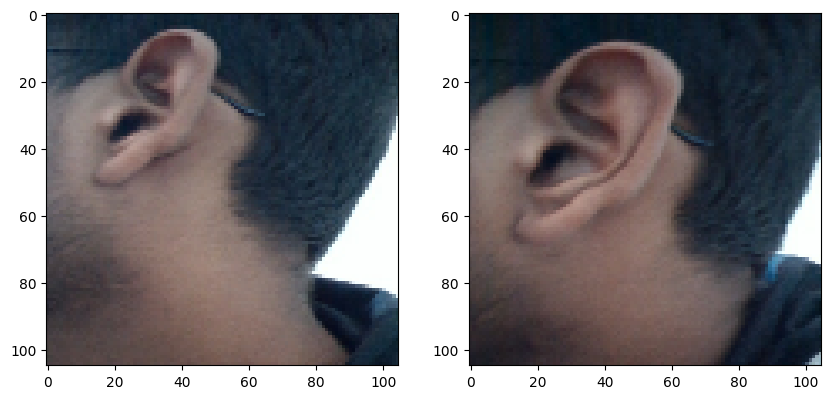

In [72]:
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(testinput[2])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(testval[2])

# Renders cleanly
plt.show()

## Verification Part

In [73]:
verifydir = os.path.join('../application_data', 'verficationimg')
inpdir = os.path.join('../application_data', 'inputimg')

In [75]:
def verify(frame, model, detectionth, verificationth):
    results = []
    for img in os.listdir(verifydir):
        inputimg = preprocess(os.path.join(inpdir, 'inputimg.jpg'))
        validationimg = preprocess(os.path.join(verifydir, img))
        result = model.predict(list(np.expand_dims([inputimg, validationimg], axis=1)))
        results.append(result)
    detection = np.sum(np.array(results) > detectionth)
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verificationth
    return results, verified
        
        